In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import os
from joblib import dump, load
from PIL import Image
from tqdm.notebook import tqdm
from torch.nn.functional import relu
from torch.utils.data import DataLoader, Dataset
from SHG import SHG
from utils import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

In [2]:
""" PATHS """
# Bottleneck data path
DATA_PATH_FULL = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/train_full_skeleton/" # Only full skeletons
DATA_PATH_ALL = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/train_all/" # all skeletons

# Ground truth heatmaps
HEATMAPS_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/train/heatmaps/"

# Saving path
SAVING_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space/"

In [3]:
""" LOADING DATA - FULL SKELETONS """
X, y, IDs = load_data(DATA_PATH_FULL, HEATMAPS_PATH)
X = np.array(X).reshape((len(X), X[0].shape[0]))

In [8]:
""" Exploring components - full skeletons"""

PRINCIPAL_COMPONENTS = [0, 1, 2, 9, 29, 49, 99, X.shape[1] - 1]
STEP_SIZES = [1, 2, 3]

positive_components = [[] for _ in range(len(PRINCIPAL_COMPONENTS))]
negative_components = [[] for _ in range(len(PRINCIPAL_COMPONENTS))]
centroids = []
explained_variance_ratios = []

pca = PCA(n_components=X.shape[1]).fit(X)
X_transformed = pca.transform(X)
X_transformed_mean = np.mean(X_transformed, axis = 0)
cum_sum = np.cumsum(pca.explained_variance_ratio_)

for i, PC in enumerate(PRINCIPAL_COMPONENTS):
    centroids.append(draw_skeleton(turn_featuremaps_to_keypoints(y[np.argmin(np.linalg.norm(X_transformed_mean - X_transformed, axis = 1))])))
    std = np.sqrt(pca.explained_variance_[PC])
    explained_variance_ratios.append(pca.explained_variance_ratio_[PC])

    for step in STEP_SIZES:

        # "Walk" out from the mean sample in positive and negative direction
        centroid_positive = np.copy(X_transformed_mean)
        centroid_positive[PC] += step * std

        centroid_negative = np.copy(X_transformed_mean)
        centroid_negative[PC] -= step * std

        # Find the distances from the positive/negative walk to for each other sample
        positive_dists = np.linalg.norm(X_transformed - centroid_positive, axis = 1)
        negative_dists = np.linalg.norm(X_transformed - centroid_negative, axis = 1)

        # Find the closest point for the positve/negative walk
        positive_closest_point = y[np.argmin(positive_dists)]
        negative_closest_point = y[np.argmin(negative_dists)]

        # Drawing
        positive_kp = turn_featuremaps_to_keypoints(positive_closest_point)
        negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)
        positive_skeleton = draw_skeleton(positive_kp)
        negative_skeleton = draw_skeleton(negative_kp)

        # Storing
        positive_components[i].append(positive_skeleton)
        negative_components[i].append(negative_skeleton)


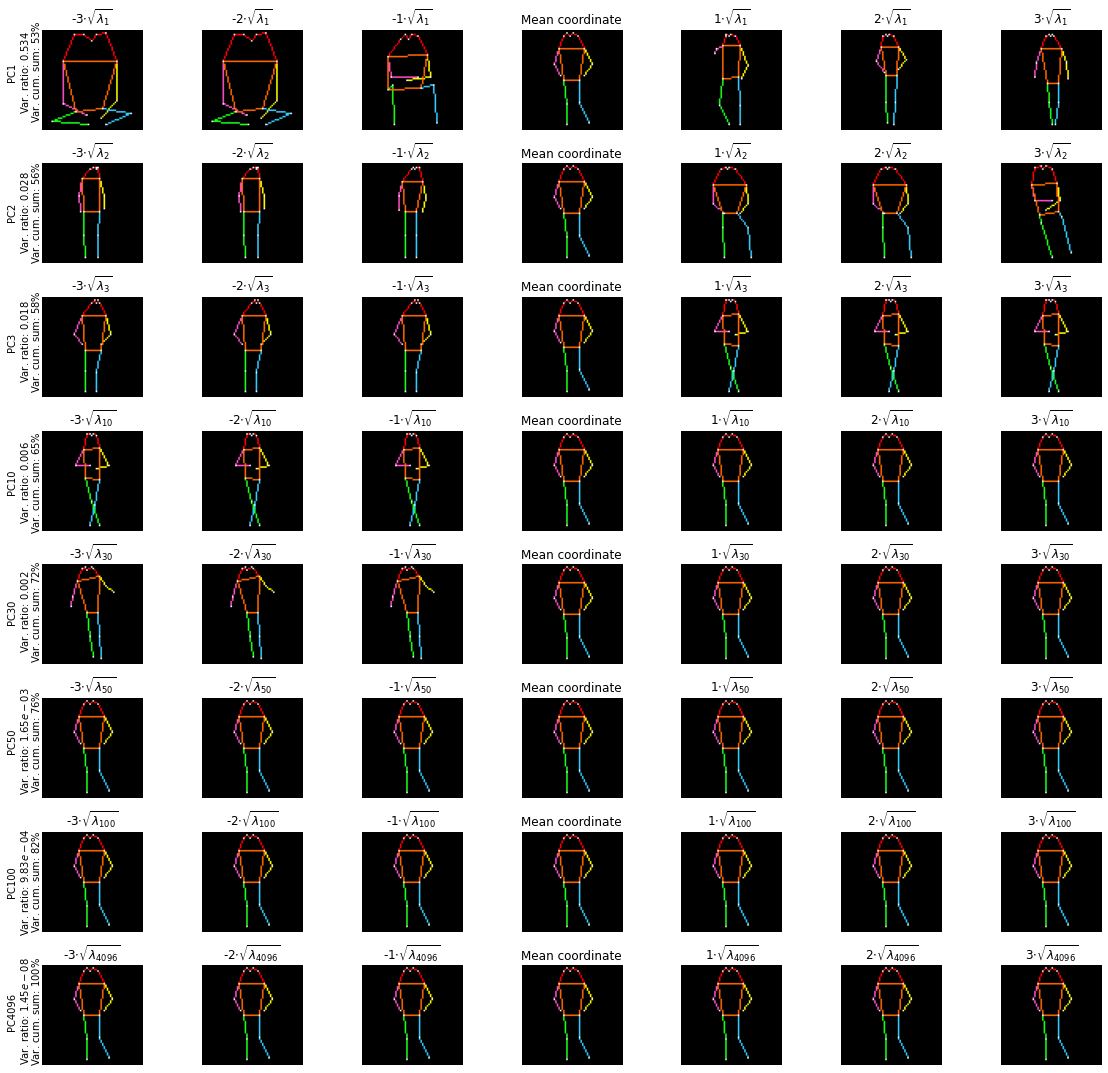

In [9]:
""" Making subplot - full skeletons"""
fig, axs = plt.subplots(len(PRINCIPAL_COMPONENTS), len(STEP_SIZES) * 2 + 1, figsize = (16, 15))

for i in range(len(PRINCIPAL_COMPONENTS)):
    for step in range(len(STEP_SIZES)):
        axs[i, len(STEP_SIZES) + step + 1].imshow(positive_components[i][step])
        axs[i, step].imshow(list(reversed(negative_components[i]))[step])

        axs[i, len(STEP_SIZES) + step + 1].axis("off")
        axs[i, step].axis("off")

        axs[i, len(STEP_SIZES) + step + 1].set_title(f"${step + 1}$" + "$\cdot \sqrt{" + "\lambda_{" + "{}".format(PRINCIPAL_COMPONENTS[i] + 1) + "}}$", size = "large")
        axs[i, step].set_title(f"-${len(STEP_SIZES) - step}$" + "$\cdot \sqrt{" + "\lambda_{" + "{}".format(PRINCIPAL_COMPONENTS[i] + 1) + "}}$", size = "large")

    axs[i, len(STEP_SIZES)].imshow(centroids[i])
    axs[i, len(STEP_SIZES)].axis("off")
    axs[i, len(STEP_SIZES)].set_title("Mean coordinate", size = "large")

fig.text(0.01, 0.93, "PC1", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.93, "Var. ratio: ${:.3f}$".format(explained_variance_ratios[0]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.93, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[0] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.80, "PC2", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.80, "Var. ratio: ${:.3f}$".format(explained_variance_ratios[1]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.80, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[1] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.68, "PC3", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.68, "Var. ratio: ${:.3f}$".format(explained_variance_ratios[2]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.68, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[2] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.55, "PC10", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.55, "Var. ratio: ${:.3f}$".format(explained_variance_ratios[3]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.55, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[9] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.43, "PC30", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.43, "Var. ratio: ${:.3f}$".format(explained_variance_ratios[4]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.43, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[29] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.31, "PC50", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.31, "Var. ratio: ${:.2e}$".format(explained_variance_ratios[5]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.31, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[49] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.18, "PC100", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.18, "Var. ratio: ${:.2e}$".format(explained_variance_ratios[6]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.18, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[99] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.06, "PC4096", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.06, "Var. ratio: ${:.2e}$".format(explained_variance_ratios[7]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.06, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[4095] * 100))), va = "center", rotation = "vertical", size = "medium")

plt.tight_layout()
#plt.savefig("C:/Users/André/OneDrive 2/OneDrive/Skrivebord/shape_analysis.png")
plt.show()

In [4]:
""" Exploring components in negative direction - full skeletons"""

PRINCIPAL_COMPONENTS = [0, 1, 2, 9, 29, 49, 99, X.shape[1] - 1]
STEP_SIZES = [2, 2.25, 2.5, 2.75, 3]

negative_components = [[] for _ in range(len(PRINCIPAL_COMPONENTS))]
centroids = []
explained_variance_ratios = []

pca = PCA(n_components=X.shape[1]).fit(X)
X_transformed = pca.transform(X)
X_transformed_mean = np.mean(X_transformed, axis = 0)
cum_sum = np.cumsum(pca.explained_variance_ratio_)

for i, PC in enumerate(PRINCIPAL_COMPONENTS):
    centroids.append(draw_skeleton(turn_featuremaps_to_keypoints(y[np.argmin(np.linalg.norm(X_transformed_mean - X_transformed, axis = 1))])))
    std = np.sqrt(pca.explained_variance_[PC])
    explained_variance_ratios.append(pca.explained_variance_ratio_[PC])

    for step in STEP_SIZES:

        # "Walk" out from the mean sample
        centroid_negative = np.copy(X_transformed_mean)
        centroid_negative[PC] -= step * std

        # Find the distances from the negative walk to for each other sample
        negative_dists = np.linalg.norm(X_transformed - centroid_negative, axis = 1)

        # Find the closest point for the negative walk
        negative_closest_point = y[np.argmin(negative_dists)]

        # Drawing
        negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)
        negative_skeleton = draw_skeleton(negative_kp)

        # Storing
        negative_components[i].append(negative_skeleton)


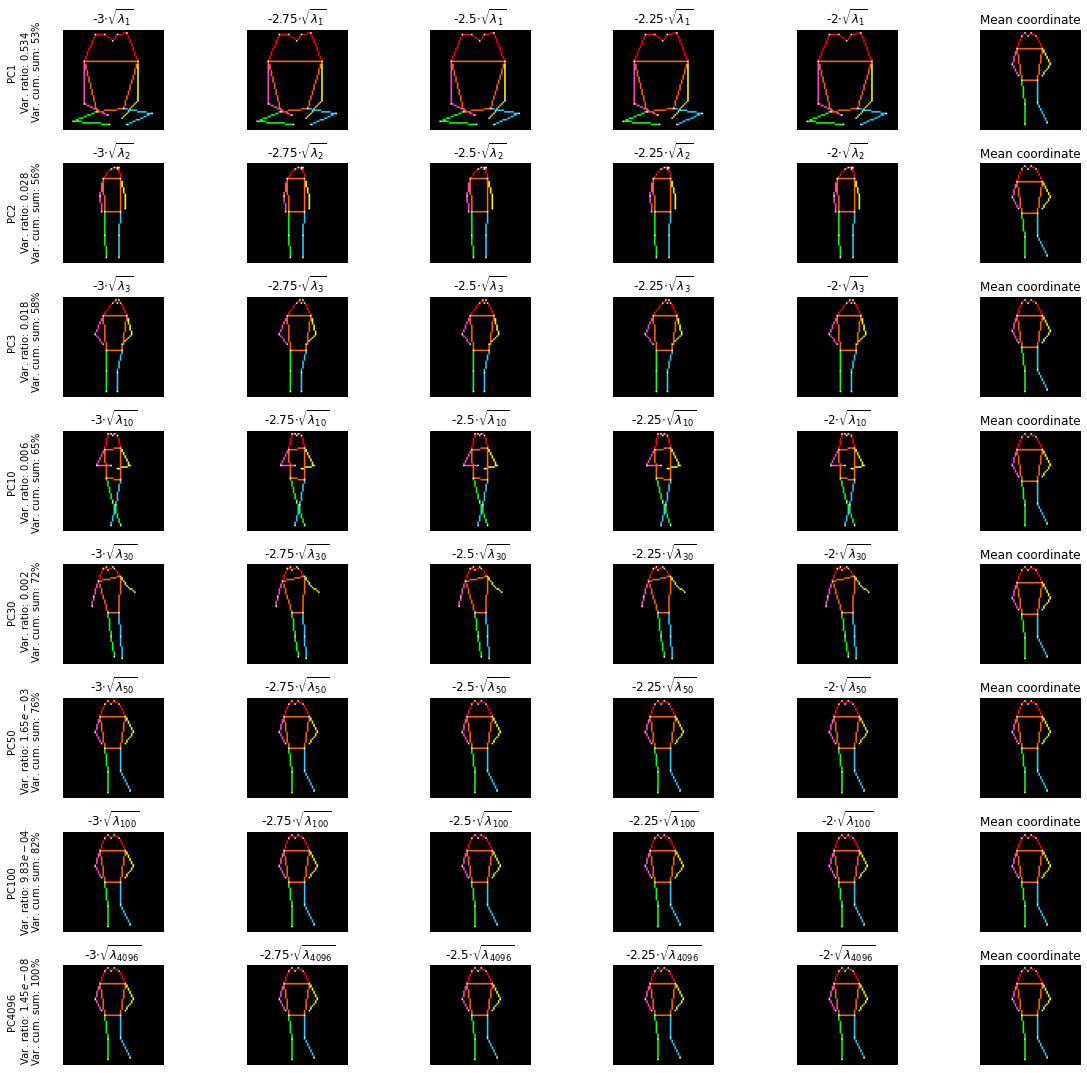

In [8]:
""" Making subplot - full skeletons"""
fig, axs = plt.subplots(len(PRINCIPAL_COMPONENTS), len(STEP_SIZES) + 1, figsize = (16, 15))

for i in range(len(PRINCIPAL_COMPONENTS)):
    for step in range(len(STEP_SIZES)):
        axs[i, step].imshow(list(reversed(negative_components[i]))[step])
        axs[i, step].axis("off")
        axs[i, step].set_title(f"-${list(reversed(STEP_SIZES))[step]}$" + "$\cdot \sqrt{" + "\lambda_{" + "{}".format(PRINCIPAL_COMPONENTS[i] + 1) + "}}$", size = "large")

    axs[i, len(STEP_SIZES)].imshow(centroids[i])
    axs[i, len(STEP_SIZES)].axis("off")
    axs[i, len(STEP_SIZES)].set_title("Mean coordinate", size = "large")

fig.text(0.01, 0.93, "PC1", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.93, "Var. ratio: ${:.3f}$".format(explained_variance_ratios[0]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.93, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[0] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.80, "PC2", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.80, "Var. ratio: ${:.3f}$".format(explained_variance_ratios[1]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.80, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[1] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.68, "PC3", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.68, "Var. ratio: ${:.3f}$".format(explained_variance_ratios[2]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.68, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[2] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.55, "PC10", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.55, "Var. ratio: ${:.3f}$".format(explained_variance_ratios[3]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.55, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[9] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.43, "PC30", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.43, "Var. ratio: ${:.3f}$".format(explained_variance_ratios[4]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.43, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[29] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.31, "PC50", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.31, "Var. ratio: ${:.2e}$".format(explained_variance_ratios[5]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.31, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[49] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.18, "PC100", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.18, "Var. ratio: ${:.2e}$".format(explained_variance_ratios[6]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.18, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[99] * 100))), va = "center", rotation = "vertical", size = "medium")

fig.text(0.01, 0.06, "PC4096", va = "center", rotation = "vertical", size = "medium")
fig.text(0.02, 0.06, "Var. ratio: ${:.2e}$".format(explained_variance_ratios[7]), va = "center", rotation = "vertical", size = "medium")
fig.text(0.03, 0.06, "Var. cum. sum: ${}$%".format(int(np.round(cum_sum[4095] * 100))), va = "center", rotation = "vertical", size = "medium")

plt.tight_layout()
plt.savefig("C:/Users/André/OneDrive 2/OneDrive/Skrivebord/shape_analysis.png")
plt.show()